# Inits

In [2]:
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
import subprocess
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np

# Reading and formatting data

## Read in data
Gilbert provides two datasets, one containing all the info about the sgRNAs, other one containing all of what he generated about the annotated genes. Both are imported, and distances between 5' of the PAM and both ends of the primary and secondary TSS sites of the gene are calculated, for usage in the model.

In [268]:
# dataframe containing sequences, targeted genes, and scores
df = pd.read_excel("data/elife-19760-supp1-v2.xlsx")
df = df.rename(columns = {"sgRNA sequence": "sequence",
                          "gene symbol": "gene",
                          "distance_to_CAGE": "distance",
                          "sgRNA length (including PAM)": "length",
                          "PAM genomic coordinate [hg19]" : "PAM_coord",
                          "CRISPRi activity score [Horlbeck et al., eLife 2016]": "score"})

# dataframe containing annotated gene locations
gene_df = pd.read_excel("data/elife-19760-supp2-v2.xlsx")
gene_df = gene_df.rename(columns = {"Primary TSS, 5'": "prim_TSS_5p",
                                    "Primary TSS, 3'": "prim_TSS_3p",
                                    "Secondary TSS, 5'": "sec_TSS_5p",
                                    "Secondary TSS, 3'": "sec_TSS_3p"})

# merging the two, determining distance between PAM and TSS
df = pd.merge(df, gene_df, on = ("gene", "chromosome"), how = "left")
df["prim_TSS_dist5p"] = df["PAM_coord"] - df["prim_TSS_5p"]
df["prim_TSS_dist3p"] = df["PAM_coord"] - df["prim_TSS_3p"]
df["sec_TSS_dist5p"] = df["PAM_coord"] - df["sec_TSS_5p"]
df["sec_TSS_dist3p"] = df["PAM_coord"] - df["sec_TSS_3p"]
df = df[(df["prim_TSS_dist5p"] > -3000) & (df["prim_TSS_dist5p"] < 3000)]

## Linearizing TSS distance
Gilbert's paper mentions linearizing primary and secondary distance to TSS using an SVR, and then using the outputs of the SVM as variables for the distance from TSS. Not quite sure why this works, or why they need to be linearized.

C:\Users\Jackson\AppData\Local\Temp\ipykernel_37220\1611134182.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby("X_bin")["score"].mean().reset_index()
C:\Users\Jackson\AppData\Local\Temp\ipykernel_37220\1611134182.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby("X_bin")["score"].mean().reset_index()


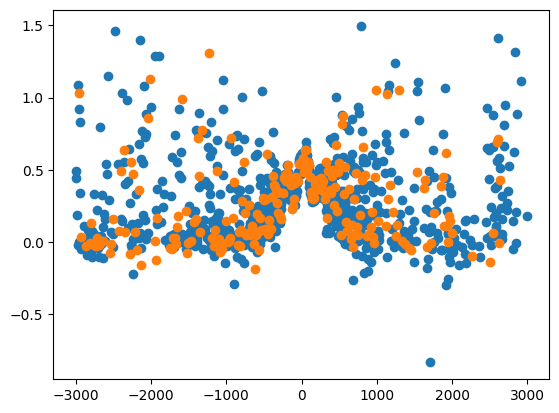

In [271]:
df = df.dropna()
X = df.loc[:, ["prim_TSS_dist5p"]]
y = df.loc[:, "score"]

# splitting training/test sets
perc_test = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = perc_test, random_state = 42)

def bin_and_average(df, bins):    
    df["X_bin"] = pd.cut(df["prim_TSS_dist5p"], bins = bins)
    
    bin_means = df.groupby("X_bin")["score"].mean().reset_index()
    bin_means["center"] = bin_means["X_bin"].apply(lambda row: row.left + (np.abs(row.left - row.right) / 2))
    
    return bin_means.dropna()

concat_df = pd.concat([X_train, y_train], axis = 1)
num_bins = 2000
binned_df = bin_and_average(concat_df, int((1 - perc_test) * num_bins))

binned_test_df = bin_and_average(pd.concat([X_test, y_test], axis = 1), int(perc_test * num_bins))

plt.scatter(binned_df["center"], binned_df["score"])
plt.scatter(binned_test_df["center"], binned_test_df["score"])

In [272]:
# fitting SVR
regr = svm.SVR(kernel = "rbf")
# parameters = {'C':[100], "gamma": [0.1], "epsilon": [0.1]}
# regr = GridSearchCV(regr, parameters, cv = 5, n_jobs = -1)
# regr.fit(binned_df["center"].to_numpy().reshape(-1, 1), binned_df["score"].to_numpy().reshape(-1, 1))

# print(f"R^2: {regr.score(binned_test_df['center'].to_numpy().reshape(-1, 1), binned_test_df['score'].to_numpy().reshape(-1, 1))}")


regr.fit(X_train, y_train)

print(f"R^2: {regr.score(X_test, y_test)}")

R^2: -0.02416708744095475


c:\Users\Jackson\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


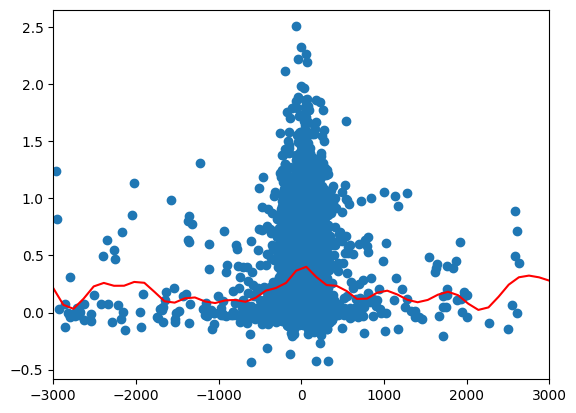

In [273]:
plot_X = np.linspace(-3000, 3000).reshape(-1, 1)
y_pred = regr.predict(plot_X)

# plt.scatter(binned_test_df["center"], binned_test_df["score"])
plt.scatter(X_test, y_test)
plt.plot(plot_X, y_pred, color = "red")
plt.xlim(-3000, 3000)
plt.show()

## Running off-target analysis for each sgRNA

In [19]:
# normalize all sgRNAs to have the same length as the max length sgRNA (by adding Ns in front)
max_len = df["sequence"].apply(len).max()

def normalize_str_len(str, max_len):
    while len(str) < max_len:
        str = "N" + str
    return(str)

df["sequence"] = df["sequence"].apply(normalize_str_len, args = (max_len,))

# preparing input strings for cas-offinder
pam = "NGG"
full_pam = ("N" * max_len) + pam

co_input = f"../genomes/human_hg19\n{full_pam} 2 1"
for i, seq in enumerate(df["sequence"], start = 1):
    co_input = co_input + f"\n{seq}NNN 3 Seq{i}"

# write input string to input.txt for cas-offinder
with open("input.txt", "w") as file:
    file.write(co_input)

# running subprocess for cas-offinder (WARNING: MAY TAKE A VERY LONG TIME TO RUN)
subprocess.run(f".\cas-offinder input.txt G output.txt")

co_output = pd.read_csv("output.txt", sep = "\t", comment = "#", header = None)
co_output.columns = ["WT", "chromosome", "posn", "OT", "dir", "mismatches"]

## Matching number of off-targets (and average number of mismatches)

In [20]:
co_output["WT"] = co_output["WT"].str.slice(0, -3)
grouped_output = co_output.groupby("WT")
grouped_num_ots = grouped_output["OT"].size()
grouped_avg_mms = grouped_output["mismatches"].mean()

df = pd.merge(df, grouped_num_ots, left_on = "sequence", right_on = "WT")
df = pd.merge(df, grouped_avg_mms, left_on = "sequence", right_on = "WT")

## Adding in GC content

In [21]:
def determine_GC_content(seq):
    GC = seq.count("C") + seq.count("G")
    return (GC / len(seq.replace("N", "")))

df["GC_content"] = df["sequence"].apply(determine_GC_content)

## Adding off-target scores for each sgRNA
This code theoretically works, but I'm sidelining it for now as it seems like scoring sgRNAs that are not exactly 20 bp is not super easy of a task

In [22]:
def calc_row_cfd(wt, ot):
    wt = wt[:-3]
    num_Ns = wt.count("N")
    ot = ot[num_Ns:-4].upper() # get rid of the region following PAM, making the two same length
    wt = wt[num_Ns:-3] + ot[-3:] # modify PAMs and beginning sequences to match
    
    # just to make things a bit more bulletproof
    if len(wt) != len(ot):
        Exception("WT and OT are not same length")
    
    return calc_cfd(wt, ot, pam.replace("N", ""))

mismatch_penalty = {
    'A': {'A': 0, 'C': 1, 'G': 1, 'T': 1},
    'C': {'A': 1, 'C': 0, 'G': 1, 'T': 1},
    'G': {'A': 1, 'C': 1, 'G': 0, 'T': 1},
    'T': {'A': 1, 'C': 1, 'G': 1, 'T': 0}
}

def calc_row_mit(wt, ot):
    wt = wt[:-3]
    num_Ns = wt.count("N")
    ot = ot[num_Ns:-7].upper() # get rid of the region following PAM, making the two same length
    wt = wt[num_Ns:] # modify PAMs and beginning sequences to match
    
    score = 1
    for i in range(len(wt)):
        if wt[i] != ot[i]:
            score *= (1 - mismatch_penalty[wt[i]][ot[i]])
        return(score)
   
co_output["MIT_score"] = co_output.apply(lambda row: calc_row_mit(row["WT"], row["OT"]), axis = 1)
print(co_output)

                          WT chromosome      posn  \
0    AAAGGATCATCACGAAACTCTGG       chr1  55766903   
1    ACTGGGCTAACCTAAAGCTGTGG       chr1  25224175   
2    CTCTGAGCCACATTGAGGGGAGG       chr1  34494917   
3    GCAAACTCAATACCTGCCCAAGG       chr1  56865260   
4    ATCTTGGCACAATGATAACAGGG       chr1  90860282   
..                       ...        ...       ...   
781  GGGGAAGGACAAGAAGGAGAAGG       chrY  14143614   
782  GGGGAAGGACAAGAAGGAGAAGG       chrY  19422901   
783  GAGGAGGGAGGAGGTGGCAGTGG       chrY   1804633   
784  TCAGCTGCCTACTTCCTCCATGG       chrY  23041639   
785  TCAGCTGCCTACTTCCTCCATGG       chrY  23041639   

                                 OT dir  mismatches  MIT_score  
0    AAAGGATCATCACaAcACTCaGGTGGTGGT   +           3          1  
1    tCTGGGCcAACCTcAAGCTGTGGGGGCTGA   +           3          0  
2    CTCTGAGCCtCATTGtGGGGtGGAGGAGGG   -           3          1  
3    GCAAACcCAATAgCTGCCCAcGGGGGCTGG   +           3          1  
4    ATgTTGGCACAATGtTAAtAGGGAGGGAAA   

# Constructing SVM

In [23]:
df = df.dropna()

X = df.loc[:, ["OT", "mismatches", "GC_content"]]
y = df.loc[:, "score"]

# splitting training/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# scaling inputs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fitting SVR
regr = svm.SVR()
regr.fit(X_train_scaled, y_train)

print(f"R^2: {regr.score(X_test_scaled, y_test)}")

R^2: -0.3155546390164041
